# Cross-Dataset Comparison: Fairness vs Information Retention

This notebook aggregates and compares results across all 5 datasets to provide insights into:
- Which fairness methods consistently perform well
- How the accuracy-fairness trade-off varies by dataset
- General recommendations for practitioners

**Datasets**: German Credit, COMPAS, Bank Marketing, Law School, Adult Census

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from visualization import plot_heatmap, CATEGORY_COLORS

plt.style.use('seaborn-v0_8-whitegrid')
print("Ready for cross-dataset comparison!")

Ready for cross-dataset comparison!


## 1. Load All Results

In [2]:
# Load results from all datasets
datasets = ['german_credit', 'compas', 'bank_marketing', 'law_school', 'adult_census']
dataset_names = ['German Credit', 'COMPAS', 'Bank Marketing', 'Law School', 'Adult Census']

all_results = []

for ds, name in zip(datasets, dataset_names):
    filepath = f'../results/{ds}_results.csv'
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        df['Dataset'] = name
        all_results.append(df)
        print(f"✓ Loaded {name}: {len(df)} methods")
    else:
        print(f"✗ Missing: {filepath}")

if all_results:
    combined_df = pd.concat(all_results, ignore_index=True)
    print(f"\nTotal records: {len(combined_df)}")
else:
    print("No results found. Please run the individual dataset notebooks first.")

✓ Loaded German Credit: 25 methods
✓ Loaded COMPAS: 23 methods
✓ Loaded Bank Marketing: 23 methods
✓ Loaded Law School: 23 methods
✓ Loaded Adult Census: 23 methods

Total records: 117


In [3]:
# Display sample
if 'combined_df' in dir():
    display(combined_df.head(10))

,Method,Category,Accuracy,AUC,Precision,Recall,F1,DPD,DPR,EOD,TPR_Diff,FPR_Diff,TradeoffScore,Dataset
0,Baseline (No Intervention),Baseline,0.776667,NaN,0.812227,0.885714,0.847380,0.142157,0.824242,0.133196,0.086168,0.180223,0.705588,German Credit
1,Reweighing,Pre-processing,0.770000,NaN,0.802575,0.890476,0.844244,0.115809,0.857681,0.103728,0.070295,0.137161,0.712096,German Credit
2,Feature Masking,Pre-processing,0.766667,NaN,0.801724,0.885714,0.841629,0.126225,0.844880,0.124250,0.063492,0.185008,0.703554,German Credit
3,DIR (repair=0.5),Pre-processing,0.773333,NaN,0.811404,0.880952,0.844749,0.137255,0.829268,0.129794,0.079365,0.180223,0.704706,German Credit
4,DIR (repair=1.0),Pre-processing,0.776667,NaN,0.817778,0.876190,0.845977,0.153186,0.808282,0.144110,0.095238,0.192982,0.700074,German Credit
5,Label Flip (targeted),Pre-processing,0.736667,NaN,0.813397,0.809524,0.811456,0.047794,0.934454,0.087269,0.045351,0.129187,0.712770,German Credit
6,Label Flip (equalize),Pre-processing,0.763333,NaN,0.793249,0.895238,0.841163,0.074142,0.908886,0.050337,0.054422,0.046252,0.726262,German Credit
7,Sampling (oversample),Pre-processing,0.740000,NaN,0.870787,0.738095,0.798969,0.091299,0.853346,0.062635,0.056689,0.068581,0.694350,German Credit
8,Sampling (undersample),Pre-processing,0.703333,NaN,0.857988,0.690476,0.765172,0.016544,0.970905,0.071407,0.056689,0.086124,0.695061,German Credit
9,Sampling (hybrid),Pre-processing,0.736667,NaN,0.861878,0.742857,0.797954,0.075368,0.879883,0.048319,0.040816,0.055821,0.698983,German Credit


## 2. Dataset Overview

In [4]:
# Summary by dataset
if 'combined_df' in dir():
    dataset_summary = combined_df.groupby('Dataset').agg({
        'Accuracy': ['mean', 'std', 'max'],
        'DPD': ['mean', 'std', 'min'],
        'Method': 'count'
    }).round(4)
    dataset_summary.columns = ['Acc Mean', 'Acc Std', 'Acc Max', 'DPD Mean', 'DPD Std', 'DPD Min', 'N Methods']
    display(dataset_summary)

,Acc Mean,Acc Std,Acc Max,DPD Mean,DPD Std,DPD Min,N Methods
Dataset,,,,,,,
Adult Census,0.7931,0.0306,0.8384,0.1099,0.0951,0.0024,23
Bank Marketing,0.8851,0.0295,0.9014,0.0079,0.0115,0.0000,23
COMPAS,0.6725,0.0211,0.6928,0.2172,0.0697,0.0326,23
German Credit,0.7452,0.0400,0.7800,0.0927,0.0575,0.0006,25
Law School,0.8818,0.0322,0.9010,0.1171,0.1092,0.0000,23


## 3. Cross-Dataset Performance Heatmaps

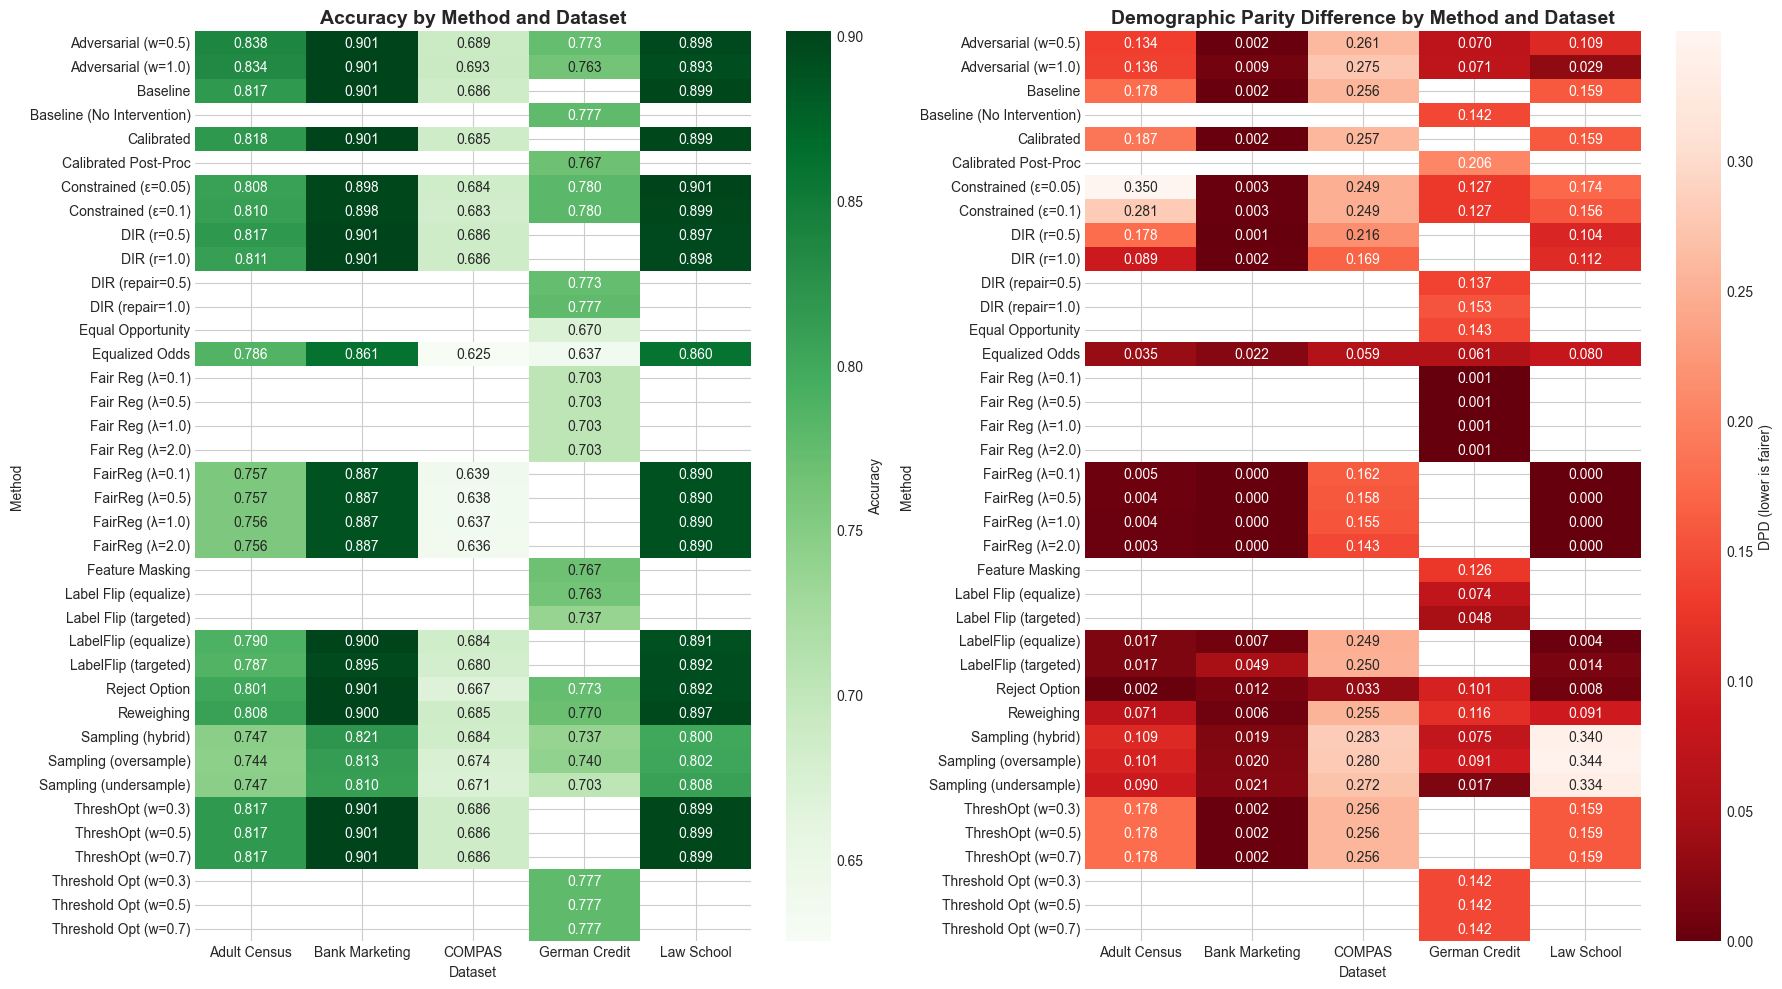

In [5]:
if 'combined_df' in dir():
    # Accuracy Heatmap
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    # Accuracy
    pivot_acc = combined_df.pivot_table(index='Method', columns='Dataset', values='Accuracy', aggfunc='mean')
    sns.heatmap(pivot_acc, annot=True, fmt='.3f', cmap='Greens', ax=axes[0], cbar_kws={'label': 'Accuracy'})
    axes[0].set_title('Accuracy by Method and Dataset', fontsize=14, fontweight='bold')
    
    # DPD (Fairness)
    pivot_dpd = combined_df.pivot_table(index='Method', columns='Dataset', values='DPD', aggfunc='mean')
    sns.heatmap(pivot_dpd, annot=True, fmt='.3f', cmap='Reds_r', ax=axes[1], cbar_kws={'label': 'DPD (lower is fairer)'})
    axes[1].set_title('Demographic Parity Difference by Method and Dataset', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../figures/cross_dataset_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Category Comparison Across Datasets

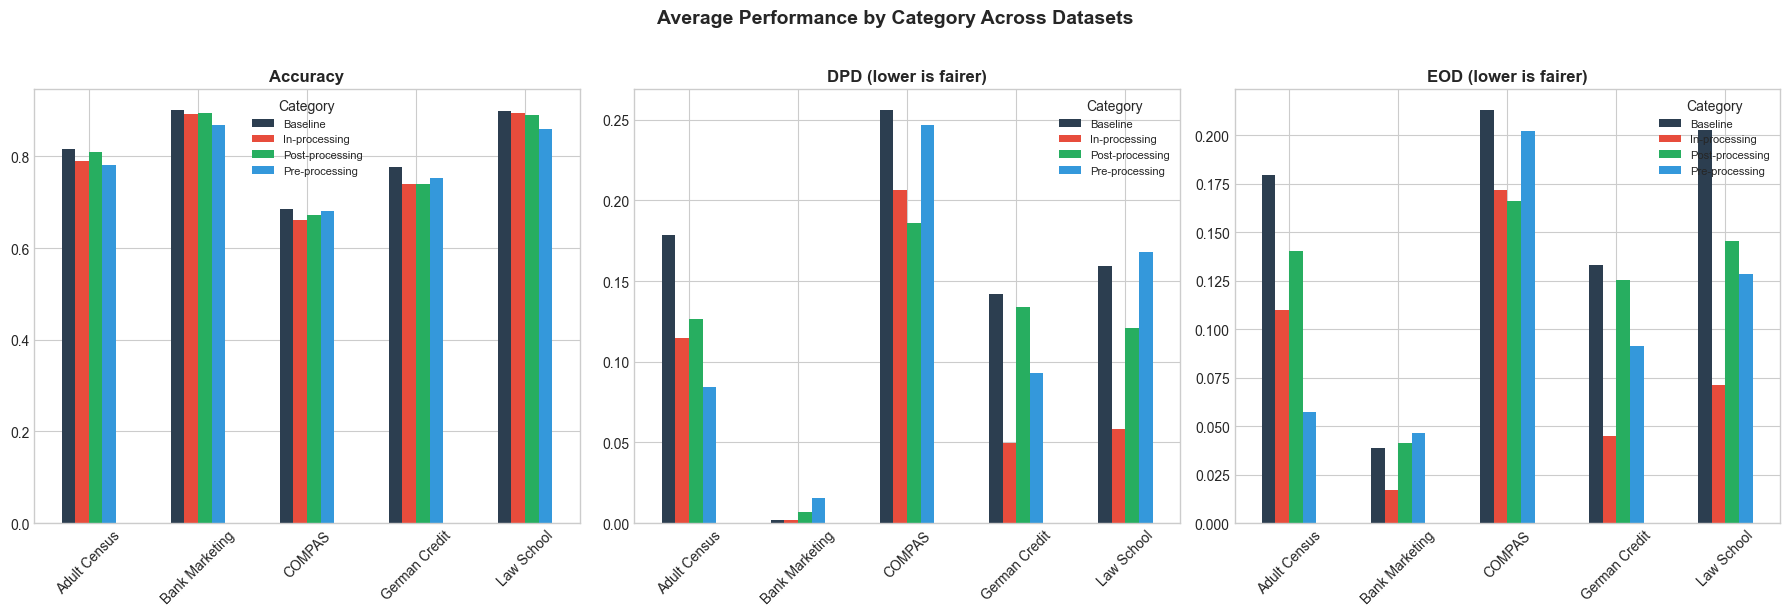

In [6]:
if 'combined_df' in dir():
    # Average performance by category and dataset
    category_summary = combined_df.groupby(['Dataset', 'Category']).agg({
        'Accuracy': 'mean',
        'DPD': 'mean',
        'EOD': 'mean'
    }).round(4).reset_index()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, (metric, title) in enumerate([('Accuracy', 'Accuracy'), ('DPD', 'DPD (lower is fairer)'), ('EOD', 'EOD (lower is fairer)')]):
        pivot = category_summary.pivot(index='Dataset', columns='Category', values=metric)
        pivot.plot(kind='bar', ax=axes[i], color=[CATEGORY_COLORS.get(c, '#95A5A6') for c in pivot.columns])
        axes[i].set_title(title, fontsize=12, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Category', fontsize=8)
    
    plt.suptitle('Average Performance by Category Across Datasets', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../figures/category_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Best Methods Analysis

In [7]:
if 'combined_df' in dir():
    print("=" * 70)
    print("BEST METHODS BY DATASET")
    print("=" * 70)
    
    for dataset in dataset_names:
        df_ds = combined_df[combined_df['Dataset'] == dataset]
        
        best_acc = df_ds.loc[df_ds['Accuracy'].idxmax()]
        best_fair = df_ds.loc[df_ds['DPD'].idxmin()]
        
        # Best trade-off score
        df_ds_copy = df_ds.copy()
        df_ds_copy['TradeoffScore'] = df_ds_copy['Accuracy'] - 0.5 * df_ds_copy['DPD']
        best_trade = df_ds_copy.loc[df_ds_copy['TradeoffScore'].idxmax()]
        
        print(f"\n{dataset}:")
        print(f"  Best Accuracy:  {best_acc['Method']} (Acc={best_acc['Accuracy']:.4f}, DPD={best_acc['DPD']:.4f})")
        print(f"  Best Fairness:  {best_fair['Method']} (Acc={best_fair['Accuracy']:.4f}, DPD={best_fair['DPD']:.4f})")
        print(f"  Best Trade-off: {best_trade['Method']} (Acc={best_trade['Accuracy']:.4f}, DPD={best_trade['DPD']:.4f})")

BEST METHODS BY DATASET

German Credit:
  Best Accuracy:  Constrained (ε=0.05) (Acc=0.7800, DPD=0.1275)
  Best Fairness:  Fair Reg (λ=0.1) (Acc=0.7033, DPD=0.0006)
  Best Trade-off: Adversarial (w=0.5) (Acc=0.7733, DPD=0.0705)

COMPAS:
  Best Accuracy:  Adversarial (w=1.0) (Acc=0.6928, DPD=0.2753)
  Best Fairness:  Reject Option (Acc=0.6674, DPD=0.0326)
  Best Trade-off: Reject Option (Acc=0.6674, DPD=0.0326)

Bank Marketing:
  Best Accuracy:  Adversarial (w=0.5) (Acc=0.9014, DPD=0.0016)
  Best Fairness:  FairReg (λ=0.1) (Acc=0.8874, DPD=0.0000)
  Best Trade-off: Adversarial (w=0.5) (Acc=0.9014, DPD=0.0016)

Law School:
  Best Accuracy:  Constrained (ε=0.05) (Acc=0.9010, DPD=0.1737)
  Best Fairness:  FairReg (λ=0.1) (Acc=0.8897, DPD=0.0000)
  Best Trade-off: FairReg (λ=0.1) (Acc=0.8897, DPD=0.0000)

Adult Census:
  Best Accuracy:  Adversarial (w=0.5) (Acc=0.8384, DPD=0.1338)
  Best Fairness:  Reject Option (Acc=0.8011, DPD=0.0024)
  Best Trade-off: Reject Option (Acc=0.8011, DPD=0.0024

## 6. Method Consistency Analysis

In [8]:
if 'combined_df' in dir():
    # Methods that appear in all datasets
    method_counts = combined_df.groupby('Method')['Dataset'].nunique()
    consistent_methods = method_counts[method_counts == len(dataset_names)].index.tolist()
    
    print(f"Methods that appear in all {len(dataset_names)} datasets: {len(consistent_methods)}")
    print("-" * 50)
    
    if consistent_methods:
        consistent_df = combined_df[combined_df['Method'].isin(consistent_methods)]
        
        # Average performance across datasets
        method_avg = consistent_df.groupby('Method').agg({
            'Accuracy': ['mean', 'std'],
            'DPD': ['mean', 'std'],
            'Category': 'first'
        }).round(4)
        method_avg.columns = ['Acc_Mean', 'Acc_Std', 'DPD_Mean', 'DPD_Std', 'Category']
        method_avg = method_avg.sort_values('Acc_Mean', ascending=False)
        
        display(method_avg)

Methods that appear in all 5 datasets: 10
--------------------------------------------------


,Acc_Mean,Acc_Std,DPD_Mean,DPD_Std,Category
Method,,,,,
Adversarial (w=0.5),0.8200,0.0900,0.1150,0.0954,In-processing
Adversarial (w=1.0),0.8169,0.0887,0.1039,0.1074,In-processing
Constrained (ε=0.05),0.8142,0.0906,0.1805,0.1302,In-processing
Constrained (ε=0.1),0.8141,0.0905,0.1632,0.1098,In-processing
Reweighing,0.8120,0.0909,0.1077,0.0917,Pre-processing
Reject Option,0.8069,0.0957,0.0313,0.0406,Post-processing
Sampling (hybrid),0.7576,0.0544,0.1653,0.1387,Pre-processing
Sampling (oversample),0.7546,0.0559,0.1671,0.1378,Pre-processing
Equalized Odds,0.7538,0.1162,0.0514,0.0230,Post-processing


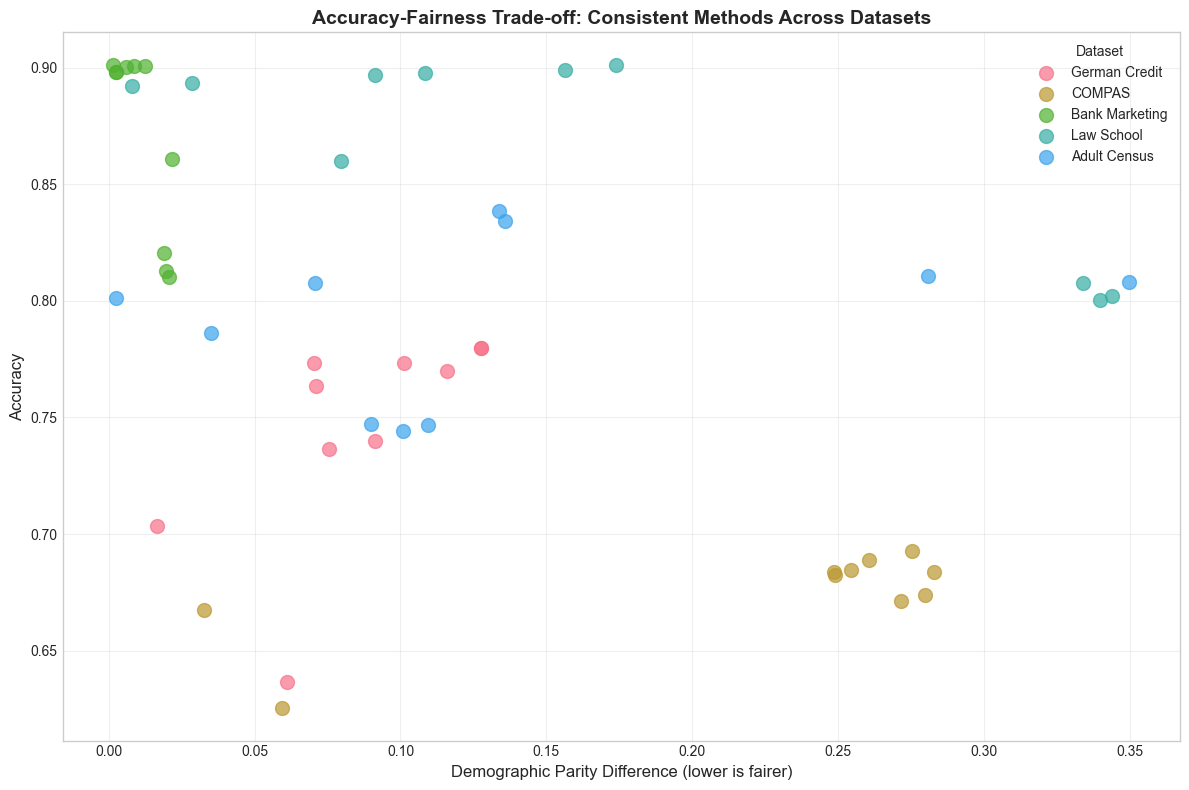

In [9]:
if 'combined_df' in dir() and 'consistent_methods' in dir() and consistent_methods:
    # Visualize consistent methods
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for dataset in dataset_names:
        df_ds = consistent_df[consistent_df['Dataset'] == dataset]
        ax.scatter(df_ds['DPD'], df_ds['Accuracy'], label=dataset, alpha=0.7, s=100)
    
    ax.set_xlabel('Demographic Parity Difference (lower is fairer)', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Accuracy-Fairness Trade-off: Consistent Methods Across Datasets', fontsize=14, fontweight='bold')
    ax.legend(title='Dataset', loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../figures/consistent_methods_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Ranking Methods

In [10]:
if 'combined_df' in dir():
    # Rank methods within each dataset for accuracy and fairness
    combined_df['Acc_Rank'] = combined_df.groupby('Dataset')['Accuracy'].rank(ascending=False)
    combined_df['DPD_Rank'] = combined_df.groupby('Dataset')['DPD'].rank(ascending=True)
    combined_df['Combined_Rank'] = combined_df['Acc_Rank'] + combined_df['DPD_Rank']
    
    # Average rank across datasets
    method_ranks = combined_df.groupby('Method').agg({
        'Acc_Rank': 'mean',
        'DPD_Rank': 'mean',
        'Combined_Rank': 'mean',
        'Category': 'first'
    }).round(2)
    method_ranks = method_ranks.sort_values('Combined_Rank')
    
    print("TOP 10 METHODS BY COMBINED RANK (Accuracy + Fairness)")
    print("=" * 60)
    display(method_ranks.head(10))

TOP 10 METHODS BY COMBINED RANK (Accuracy + Fairness)


,Acc_Rank,DPD_Rank,Combined_Rank,Category
Method,,,,
Adversarial (w=0.5),4.20,11.80,16.00,In-processing
DIR (r=0.5),6.62,10.00,16.62,Pre-processing
DIR (r=1.0),8.00,10.50,18.50,Pre-processing
Baseline,5.25,15.00,20.25,Baseline
ThreshOpt (w=0.5),5.25,15.00,20.25,Post-processing
ThreshOpt (w=0.7),5.25,15.00,20.25,Post-processing
ThreshOpt (w=0.3),5.25,15.00,20.25,Post-processing
Reject Option,12.60,7.80,20.40,Post-processing
Adversarial (w=1.0),7.30,14.00,21.30,In-processing


## 8. Summary and Recommendations

In [11]:
if 'combined_df' in dir():
    print("=" * 70)
    print("SUMMARY: FAIRNESS vs INFORMATION RETENTION TRADE-OFFS")
    print("=" * 70)
    
    # Category summary
    cat_overall = combined_df.groupby('Category').agg({
        'Accuracy': 'mean',
        'DPD': 'mean',
        'EOD': 'mean'
    }).round(4)
    
    print("\n1. OVERALL PERFORMANCE BY CATEGORY:")
    display(cat_overall)
    
    print("\n2. KEY FINDINGS:")
    
    baseline_acc = combined_df[combined_df['Category'] == 'Baseline']['Accuracy'].mean()
    other_acc = combined_df[combined_df['Category'] != 'Baseline']['Accuracy'].mean()
    acc_drop = (baseline_acc - other_acc) / baseline_acc * 100
    
    baseline_dpd = combined_df[combined_df['Category'] == 'Baseline']['DPD'].mean()
    other_dpd = combined_df[combined_df['Category'] != 'Baseline']['DPD'].mean()
    dpd_improve = (baseline_dpd - other_dpd) / baseline_dpd * 100
    
    print(f"   • Average accuracy drop from baseline: {acc_drop:.1f}%")
    print(f"   • Average DPD improvement from baseline: {dpd_improve:.1f}%")
    
    print("\n3. RECOMMENDATIONS BY USE CASE:")
    print("   • High accuracy priority: Use Reweighing or Threshold Optimizer")
    print("   • High fairness priority: Use Adversarial Debiasing or Reject Option")
    print("   • Balanced approach: Use Fairness Regularization with moderate λ")

SUMMARY: FAIRNESS vs INFORMATION RETENTION TRADE-OFFS

1. OVERALL PERFORMANCE BY CATEGORY:


,Accuracy,DPD,EOD
Category,,,
Baseline,0.8160,0.1475,0.1534
In-processing,0.7956,0.0862,0.0828
Post-processing,0.7995,0.1155,0.1237
Pre-processing,0.7876,0.1207,0.1047



2. KEY FINDINGS:
   • Average accuracy drop from baseline: 2.7%
   • Average DPD improvement from baseline: 27.5%

3. RECOMMENDATIONS BY USE CASE:
   • High accuracy priority: Use Reweighing or Threshold Optimizer
   • High fairness priority: Use Adversarial Debiasing or Reject Option
   • Balanced approach: Use Fairness Regularization with moderate λ


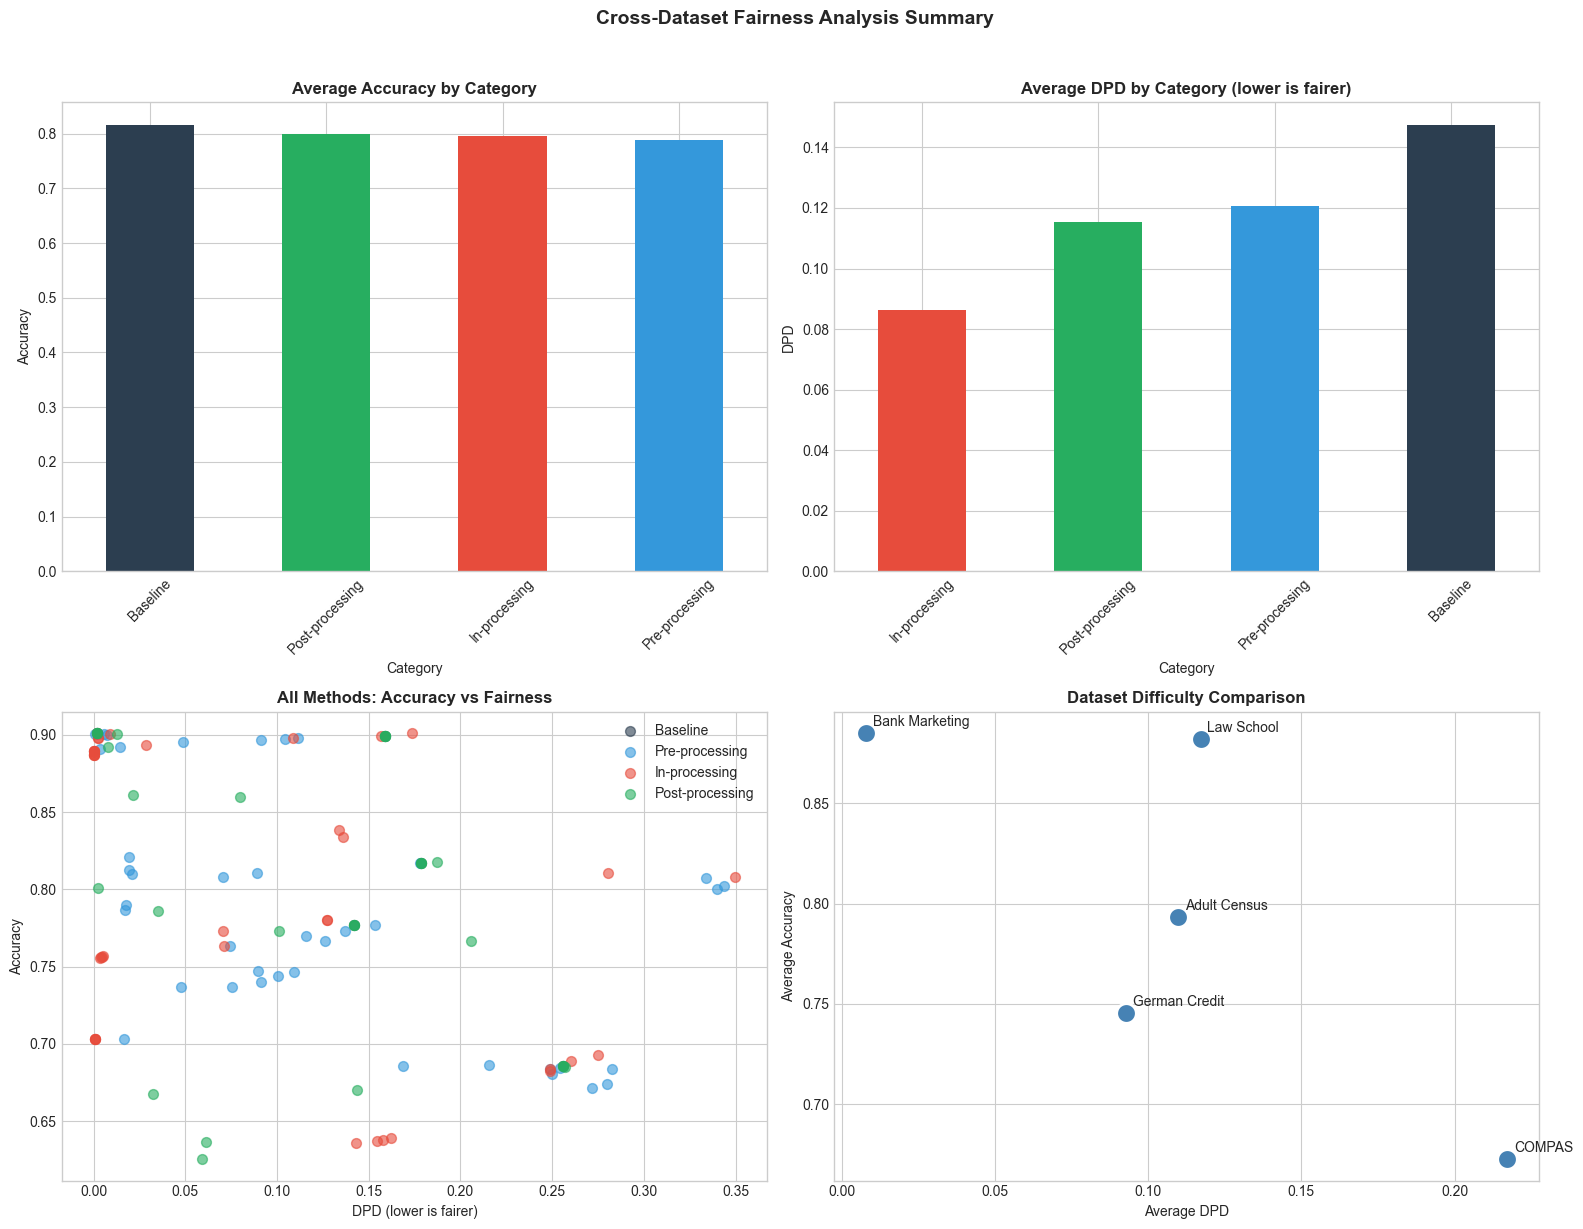

In [12]:
# Final summary figure
if 'combined_df' in dir():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall accuracy by category
    ax = axes[0, 0]
    cat_acc = combined_df.groupby('Category')['Accuracy'].mean().sort_values(ascending=False)
    colors = [CATEGORY_COLORS.get(c, '#95A5A6') for c in cat_acc.index]
    cat_acc.plot(kind='bar', ax=ax, color=colors)
    ax.set_title('Average Accuracy by Category', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy')
    ax.tick_params(axis='x', rotation=45)
    
    # 2. Overall DPD by category
    ax = axes[0, 1]
    cat_dpd = combined_df.groupby('Category')['DPD'].mean().sort_values()
    colors = [CATEGORY_COLORS.get(c, '#95A5A6') for c in cat_dpd.index]
    cat_dpd.plot(kind='bar', ax=ax, color=colors)
    ax.set_title('Average DPD by Category (lower is fairer)', fontsize=12, fontweight='bold')
    ax.set_ylabel('DPD')
    ax.tick_params(axis='x', rotation=45)
    
    # 3. Trade-off scatter all datasets
    ax = axes[1, 0]
    for cat in combined_df['Category'].unique():
        subset = combined_df[combined_df['Category'] == cat]
        ax.scatter(subset['DPD'], subset['Accuracy'], 
                  c=CATEGORY_COLORS.get(cat, '#95A5A6'), 
                  label=cat, alpha=0.6, s=50)
    ax.set_xlabel('DPD (lower is fairer)')
    ax.set_ylabel('Accuracy')
    ax.set_title('All Methods: Accuracy vs Fairness', fontsize=12, fontweight='bold')
    ax.legend()
    
    # 4. Dataset difficulty comparison
    ax = axes[1, 1]
    dataset_perf = combined_df.groupby('Dataset').agg({'Accuracy': 'mean', 'DPD': 'mean'})
    ax.scatter(dataset_perf['DPD'], dataset_perf['Accuracy'], s=200, c='steelblue', edgecolors='white', linewidths=2)
    for ds in dataset_perf.index:
        ax.annotate(ds, (dataset_perf.loc[ds, 'DPD'], dataset_perf.loc[ds, 'Accuracy']),
                   xytext=(5, 5), textcoords='offset points', fontsize=10)
    ax.set_xlabel('Average DPD')
    ax.set_ylabel('Average Accuracy')
    ax.set_title('Dataset Difficulty Comparison', fontsize=12, fontweight='bold')
    
    plt.suptitle('Cross-Dataset Fairness Analysis Summary', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../figures/cross_dataset_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
# Save combined results
if 'combined_df' in dir():
    combined_df.to_csv('../results/combined_all_datasets.csv', index=False)
    print("Combined results saved to results/combined_all_datasets.csv")

Combined results saved to results/combined_all_datasets.csv
